In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import scipy.sparse.linalg
import torch
import re
from torch.nn.functional import conv2d
%load_ext autoreload

%autoreload 2

In [2]:
from crf.utils import read_image, read_pfm, read_pgm
from crf.features import Vgg16features
from crf.crf import *
from crf.depth import *

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
def read_img(filename):
    img = Image.open(filename).convert('RGB')
    img = np.array(img).astype(float)/255
    return img

In [5]:
conv = sp.ndimage.filters.convolve

def SD(imga,imgb):
    return (imga-imgb)**2
def AD(imga,imgb):
    return np.abs(imga-imgb)
def nprod(imga,imgb):
    return -1*imga*imgb

In [6]:
img1 = read_image('imL.png')#[::2,::2]
img2 = read_image('imR.png')#[::2,::2]
#img1 = read_image('im0.png')[::3,::3]
#img2 = read_image('im1.png')[::3,::3]
#gt_depth = read_pfm('disp0.pfm')[::3,::3]
gt_depth = read_pgm('truedisp.row3.col3.pgm')

In [7]:
max_disp=30
ws = 11

nimg1 = normalized(img1,(ws,ws))
nimg2 = normalized(img2,(ws,ws))

h,w,c = nimg1.shape
padded_im1 = np.pad(nimg1,((0,0),(max_disp,0),(0,0)), mode='constant')
padded_im2 = np.pad(nimg2,((0,0),(max_disp,0),(0,0)), mode='constant')

out = np.zeros((h,w,max_disp))
for i in np.arange(max_disp):#1+np.arange(-w//2,w//2):
    shifted_nimg2 = padded_im2[:,max_disp-i:w+max_disp-i]
    out[:,:,i] = AD(nimg1,shifted_nimg2).sum(2)

In [9]:
box = np.ones((ws,ws,1))
aggregated = sp.ndimage.filters.convolve(out,box)
disps = np.argmin(aggregated,axis=-1)#*(1+.5*np.arange(max_disp)/max_disp),axis=-1)
# plt.rcParams.update({'font.size': 15, 'figure.figsize':(5,5)})
# f = plt.figure(figsize=(5,5))
# plt.imshow(disps,cmap='bone')
# plt.title("Unary (max with AD)")
#plt.colorbar()

In [10]:
gamma = 3
L = max_disp
downsampled_out = aggregated[::4,::4]
E_0 = torch.from_numpy(downsampled_out.reshape(-1,L)).float().cuda()
n = E_0.shape[0]
labels = torch.arange(L).float()
compat = lambda a,b: charbonneir(a,b,gamma)
Mu = compatibility_matrix(compat,labels).cuda()

In [86]:
VGG = Vgg16features()
VGG.cuda()
q = 2
features = VGG.get_random_features(img1,i=q)
feats = (features - features.mean((0,1)))/features.std((0,1))

In [97]:
sigma_c = .1
sigma_p = .1
sigma_f = 10
h,w,_ = downsampled_out.shape
position = np.mgrid[:h,:w].transpose((1,2,0))/np.sqrt(h**2+w**2)
ref = np.zeros((h,w,5+10))
ref[...,:3] = img1[::4,::4]/sigma_c
ref[...,3:5] = position/sigma_p
ref[...,5:] = feats[::2**(2-q),::2**(2-q)]/sigma_f
flat_ref = torch.from_numpy(ref.reshape(n,-1).astype(np.float32))
W = gaussian_weights(flat_ref.cuda())
img_W = W.reshape((h,w,h,w))

In [98]:
mf = mean_field_infer(E_0,W,Mu,niters=10)
expected_depths = mf@labels.cuda()
#expected_depths = np.argmax(mf.numpy(),axis=-1)
crf_depth = expected_depths.reshape(h,w).cpu().numpy()

Text(0.5, 1.0, 'Ground Truth')

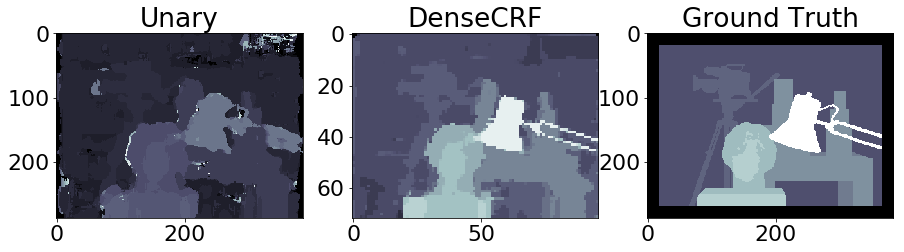

In [99]:
plt.rcParams.update({'font.size': 22})
f, axarr = plt.subplots(1,3,figsize=(15,10))
a0 = axarr[0].imshow(disps,cmap='bone')
a1 = axarr[1].imshow(crf_depth,cmap='bone')
a2 = axarr[2].imshow(gt_depth,cmap='bone')
axarr[0].set_title("Unary")
axarr[1].set_title("DenseCRF")
axarr[2].set_title("Ground Truth")

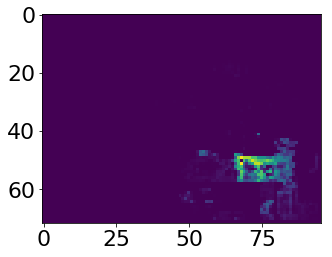

In [93]:
#plt.imshow(img_W[40,35])
plt.imshow(img_W[50,68])

In [ ]:
plt.hist(expected_depths.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


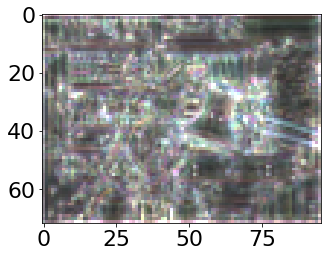

In [76]:
plt.imshow((feats[...,3:6]+3)/6)

In [68]:
feats[...,:3]

1.000000000000001